In [1]:
# Import library
import tensorflow as tf
import numpy as np
import sys, os,cv2
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation
import seaborn as sns
import scipy.linalg as LA

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

In [2]:
# Read the Data and Shuffle it 
from sklearn.datasets import fetch_olivetti_faces
from skimage.transform import rescale, resize
dataset = fetch_olivetti_faces(shuffle=True)
train_data  = dataset.data.astype(np.float64)
print('---- Before Centering -------')
print(train_data.shape)
print(train_data.min(),train_data.max())
print(train_data.mean(),train_data.std())

shuffle_index = np.random.permutation(len(train_data))
train_data = train_data[shuffle_index]

---- Before Centering -------
(400, 4096)
0.0 1.0
0.5470424729887565 0.17251528436417765


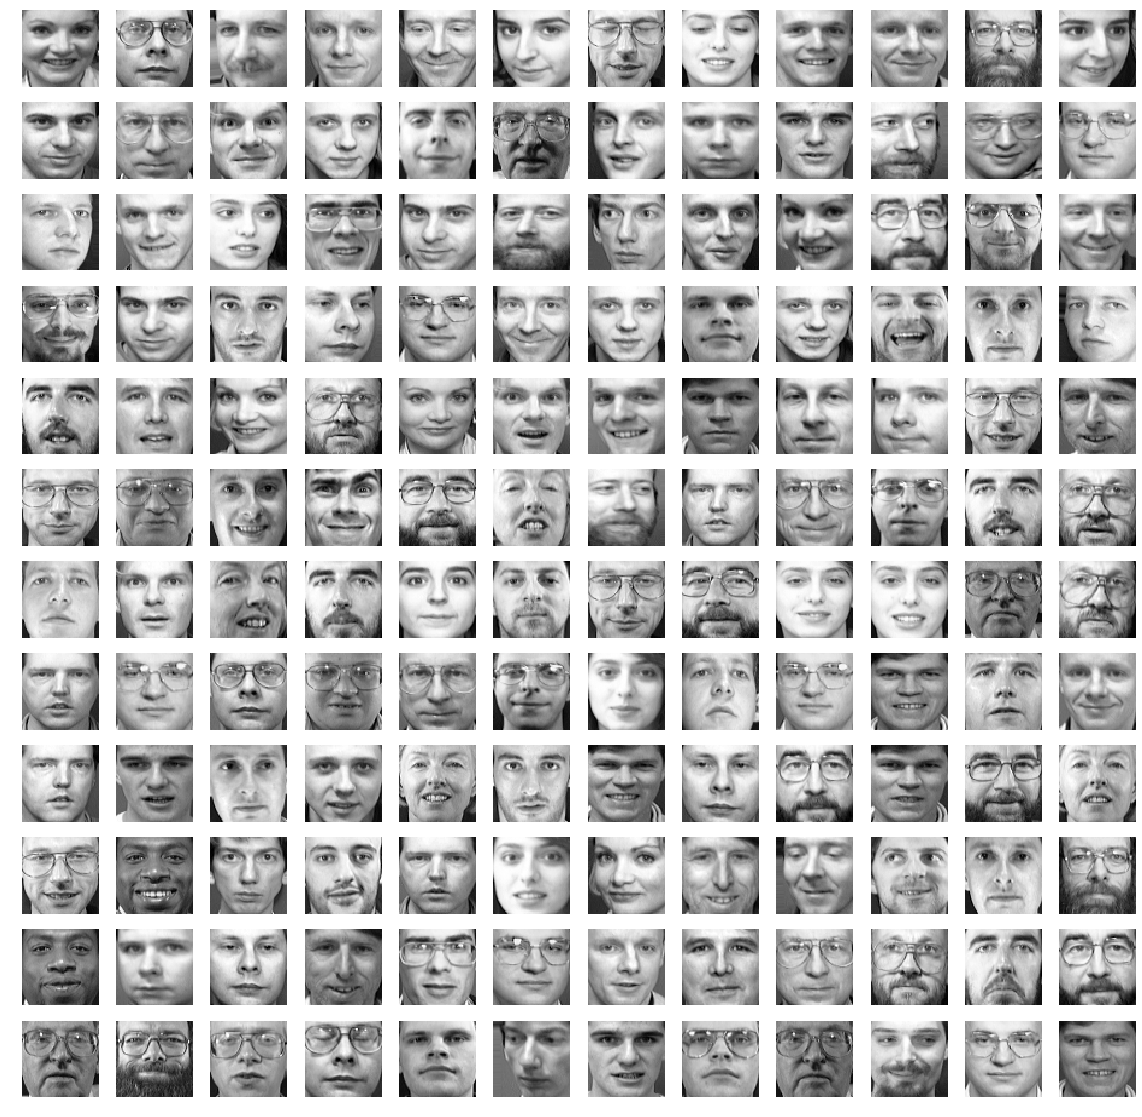

In [3]:
# view some of the data
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_data[i-1].reshape(64,64),cmap='gray')
    plt.axis('off')
plt.show()

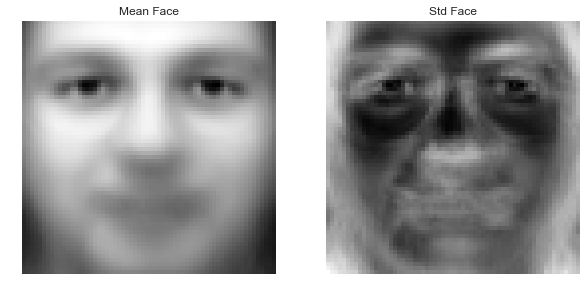

In [4]:
# center it per dimension
mean_face = train_data.mean(0); std_face = train_data.std(0)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(mean_face.reshape(64,64),cmap='gray')
plt.axis('off')
plt.title("Mean Face")

plt.subplot(122)
plt.imshow(std_face.reshape(64,64),cmap='gray')
plt.axis('off')
plt.title("Std Face")

plt.show()

---- After Centering -------
(400, 4096)
-0.640640495447442 0.6372004163265228
6.938893903907229e-19 0.13880795800960016


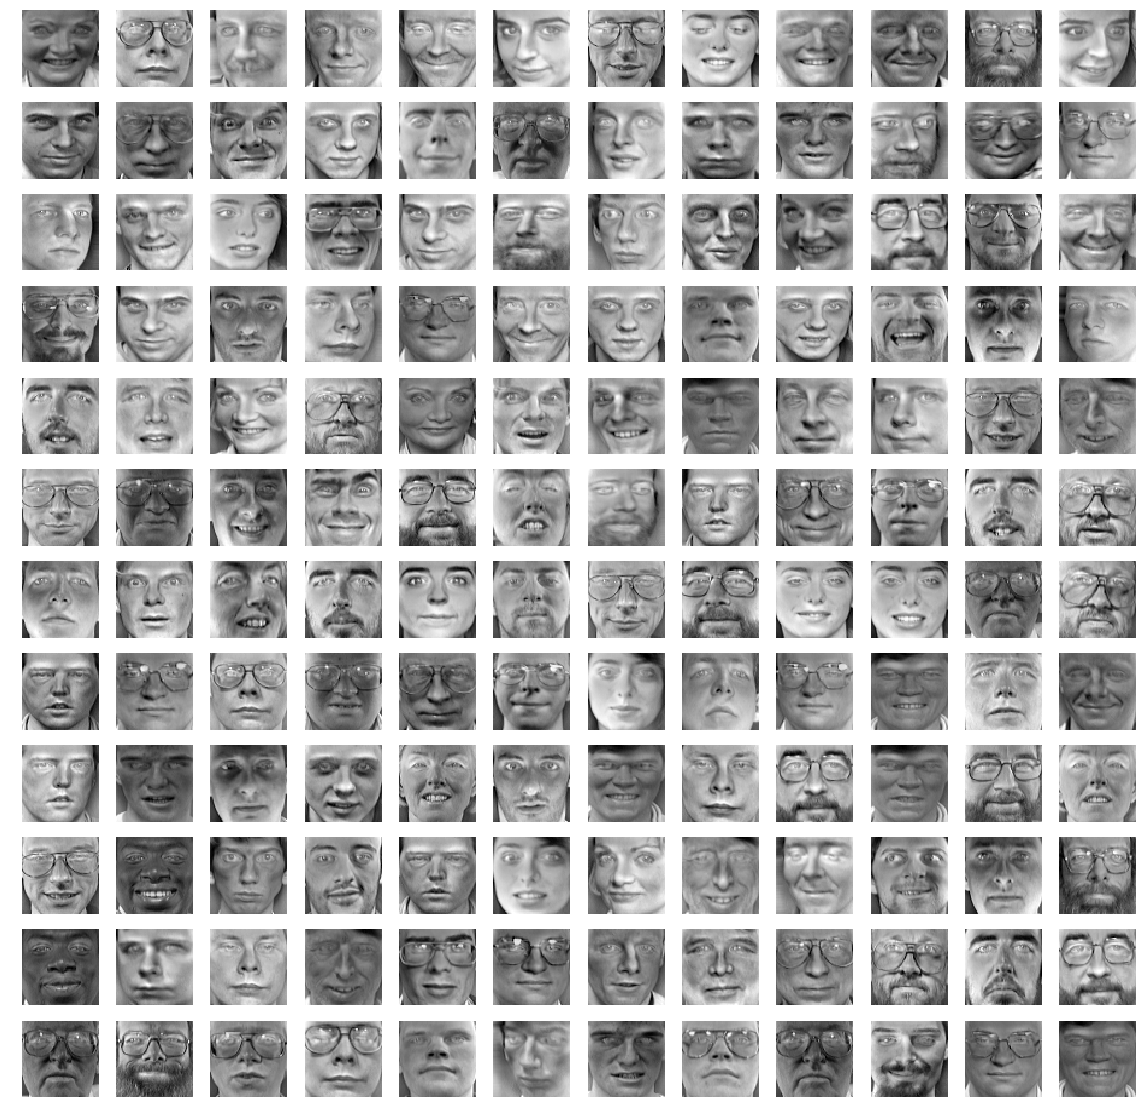

In [5]:
# center the face per dimesion and view it
centered = train_data - mean_face
print('---- After Centering -------')
print(centered.shape)
print(centered.min(),centered.max())
print(centered.mean(),centered.std())
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(centered[i-1].reshape(64,64),cmap='gray')
    plt.axis('off')
plt.show()

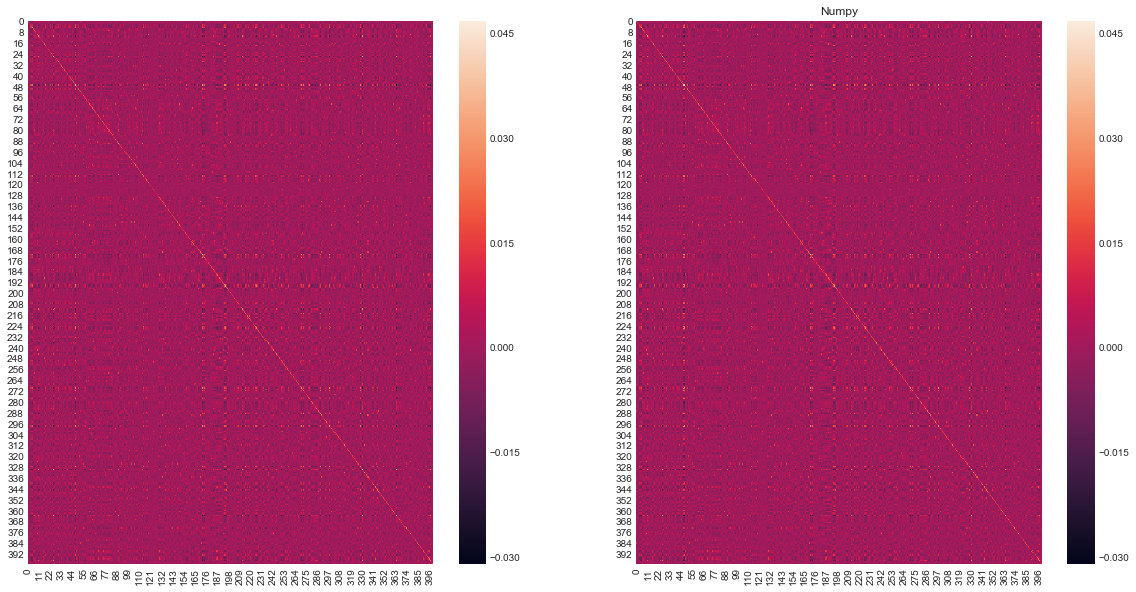

In [6]:
# calculate the co-variance 
centered_both = centered - centered.mean(1)[:,np.newaxis]
centered_both_cov = (centered_both @ centered_both.T)/centered_both.shape[1]
plt.figure(figsize=(20,10))
plt.title('Manual')
plt.subplot(121)
sns.heatmap(centered_both_cov)
plt.subplot(122)
plt.title('Numpy')
sns.heatmap(np.cov(centered,rowvar=True))
plt.show()

In [7]:
# Eigen value decomposition
evalue,evector = LA.eigh(centered_both_cov)

In [8]:
# sort the eigen values 
print('First 5 Values before sorting: ',evalue[:5])
print('Final 5 Values before sorting: ',evalue[-5:])
print('First 5 Vector Mean before sorting: ',evector[:,:5].mean())
print('Final 5 Vector Mean before sorting: ',evector[:,-5:].mean())
idx = np.argsort(evalue)[::-1]
print('-------------------------')
evalue_sort = evalue[idx]; evector_sort = evector[:,idx]
print('First 5 Values after sorting: ',evalue_sort[:5])
print('Final 5 Values after sorting: ',evalue_sort[-5:])
print('First 5 Vector Mean after sorting: ',evector_sort[:,:5].mean())
print('Final 5 Vector Mean after sorting: ',evector_sort[:,-5:].mean())

First 5 Values before sorting:  [2.25294740e-18 1.26254599e-04 1.54294092e-04 1.64793093e-04
 1.67680294e-04]
Final 5 Values before sorting:  [0.24658138 0.33915934 0.43051848 0.61670755 1.1001891 ]
First 5 Vector Mean before sorting:  -0.010000000000000021
Final 5 Vector Mean before sorting:  5.828670879282072e-19
-------------------------
First 5 Values after sorting:  [1.1001891  0.61670755 0.43051848 0.33915934 0.24658138]
Final 5 Values after sorting:  [1.67680294e-04 1.64793093e-04 1.54294092e-04 1.26254599e-04
 2.25294740e-18]
First 5 Vector Mean after sorting:  5.967448757360216e-19
Final 5 Vector Mean after sorting:  -0.010000000000000021


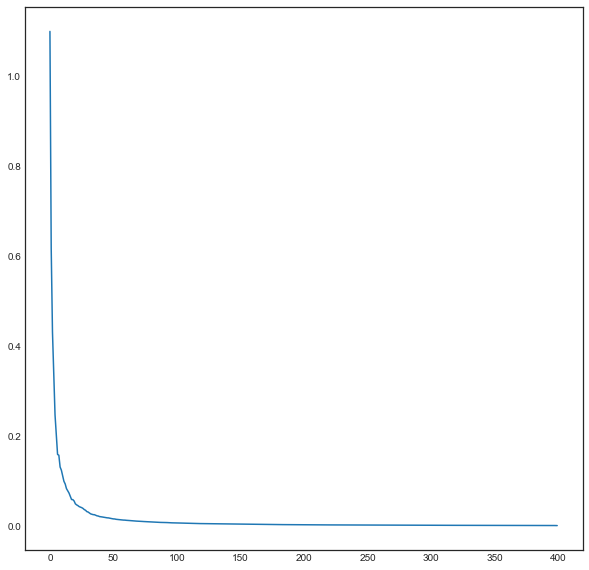

Original Eig Vector:  (400, 400)
Selected Eig Vector:  (400, 50)


In [9]:
# plot the variance of e value select 50 eigen vectors
plt.figure(figsize=(10,10))
plt.plot(evalue_sort)
plt.show()
evector_sort_small = evector_sort[:,:50]
print('Original Eig Vector: ',evector_sort.shape)
print('Selected Eig Vector: ',evector_sort_small.shape)

Reduced data Shape : (50, 4096)


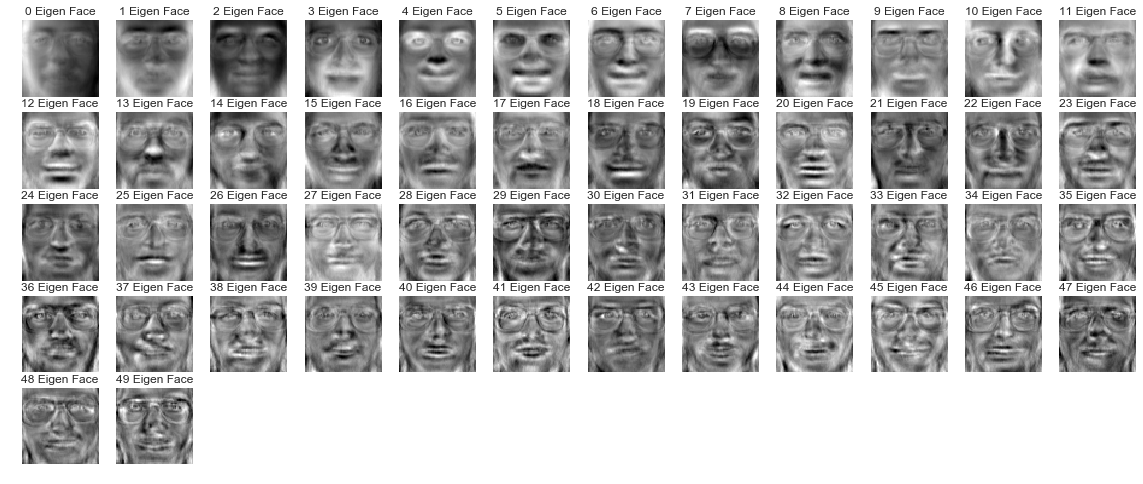

In [10]:
# project the normalized centered data to sub space
sub_centered = evector_sort_small.T @ centered_both
print('Reduced data Shape :',sub_centered.shape)
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    try: 
        sub_centered[i-1].all()
        fig.add_subplot(rows, columns, i)
        plt.imshow(sub_centered[i-1].reshape(64,64),cmap='gray')
        plt.axis('off')
        plt.title(str(i-1) + ' Eigen Face')
    except:
        pass
plt.show()

Reconstructed data Shape : (50, 4096)


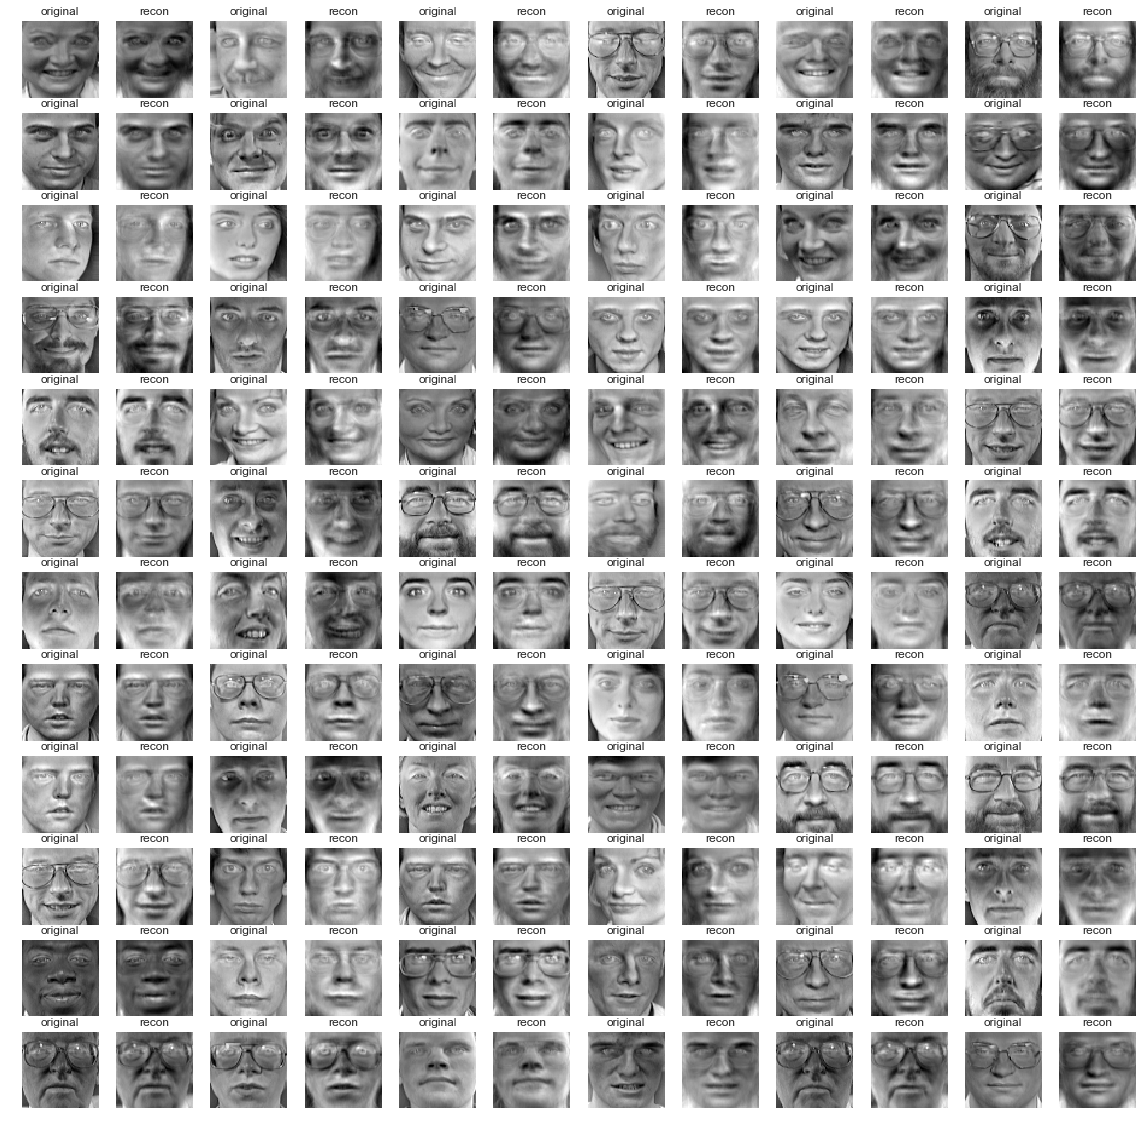

In [11]:
# Reconstruce form the small data
recon_data = evector_sort_small @ sub_centered
print('Reconstructed data Shape :',sub_centered.shape)
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if i % 2 == 0 :
        plt.title("recon")
        plt.imshow(recon_data[i-2].reshape(64,64),cmap='gray')
    else:
        plt.title("original")
        plt.imshow(centered_both[i-1].reshape(64,64),cmap='gray')
    plt.axis('off')
plt.show()

In [12]:
# Hyper Parameters
train_batch = sub_centered.copy()
num_epoch = 1000 ; learing_rate = 0.0001;print_size = 10
beta1,beta2,adam_e = 0.9,0.999, 1e-8

In [13]:
# Define Class
def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)
class FastICA_Layer():

    def __init__(self,inc,outc,act,d_act):
        self.w = tf.Variable(self.sym_decorrelation(tf.random_normal(shape=[inc,outc],stddev=0.005,dtype=tf.float64,seed=2)))
        self.m = tf.Variable(tf.zeros_like(self.w)) ; self.v = tf.Variable(tf.zeros_like(self.w))
        self.act = act; self.d_act = d_act
    
    def sym_decorrelation(self,matrix):
        s, u = tf.linalg.eigh(tf.matmul(matrix,tf.transpose(matrix)))
        decor_matrx = tf.matmul(u * (1.0/tf.sqrt(s)),tf.transpose(u))
        return tf.matmul(decor_matrx,matrix)
    
    def getw(self): return self.w
    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer
    
    def backprop_ica(self):
        self.layerA  = self.act(tf.matmul(self.w,self.input))
        self.layerDA = tf.reduce_mean(self.d_act(tf.matmul(self.w,self.input)),-1)
        grad_w = tf.matmul(self.layerA,tf.transpose(self.input)) / self.input.shape[1].value - self.layerDA * self.w
        grad_w_dec = self.sym_decorrelation(grad_w)
        update_w = []
        update_w.append(tf.assign(self.w,grad_w_dec))
        return update_w

In [14]:
# Define graph
x = tf.placeholder(shape=[50,4096],dtype=tf.float64)
fast_ica_layer = FastICA_Layer(50,50,tf_logcosh,d_tf_logcosh)
fica = fast_ica_layer.feedforward(x)
fica_w_update = fast_ica_layer.backprop_ica()

Iter:  0  mean fica:  1.4311468676808658e-18
Iter:  10  mean fica:  -7.546047120499111e-19
Iter:  20  mean fica:  -1.3530843112619096e-18
Iter:  30  mean fica:  -1.188285581044113e-18
Iter:  40  mean fica:  -2.168404344971009e-18
Iter:  50  mean fica:  -8.500145032286355e-19
Iter:  60  mean fica:  -1.0278236595162582e-18
Iter:  70  mean fica:  4.2500725161431773e-19
Iter:  80  mean fica:  8.500145032286355e-19
Iter:  90  mean fica:  -3.686287386450715e-19
Iter:  100  mean fica:  -2.0166160408230384e-18
Iter:  110  mean fica:  -2.47198095326695e-19
Iter:  120  mean fica:  -7.849623728795052e-19
Iter:  130  mean fica:  -9.107298248878238e-19
Iter:  140  mean fica:  -1.5092094240998222e-18
Iter:  150  mean fica:  -6.765421556309548e-19
Iter:  160  mean fica:  -5.464378949326942e-19
Iter:  170  mean fica:  -3.642919299551295e-19
Iter:  180  mean fica:  -1.5352302762394743e-18
Iter:  190  mean fica:  -2.38524477946811e-19
Iter:  200  mean fica:  -2.6020852139652105e-19
Iter:  210  mean fica

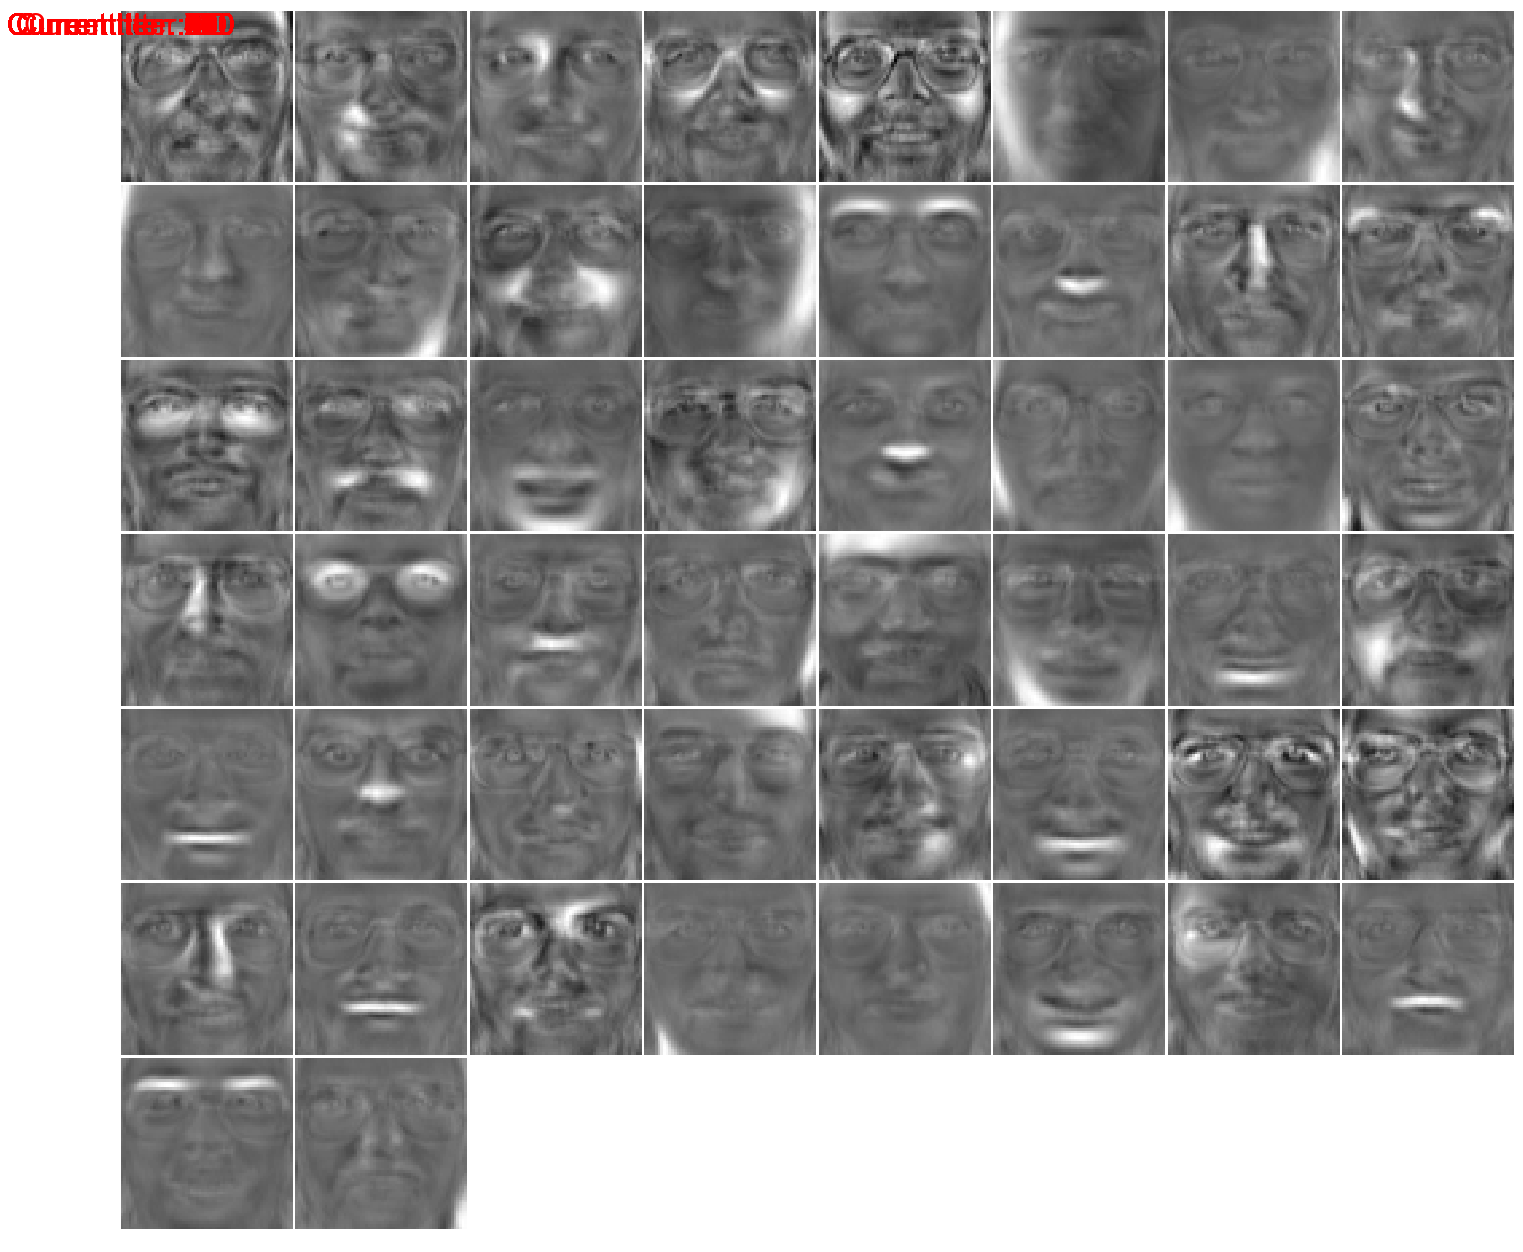

In [15]:
# Define Session and animation
import matplotlib.animation as animation
def display_network(A,current_iter=None):
    opt_normalize = True
    opt_graycolor = True
    # Rescale
    A = A - np.average(A)
    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    n = int(np.ceil(np.sqrt(col)))
    m = int(np.ceil(col / n))
    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))
    k = 0
    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue
            clim = np.max(np.abs(A[:, k]))
            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            k += 1
    plt.axis('off')
    plt.tight_layout()
    return [plt.imshow(image,cmap='gray', animated=True),plt.text(0.5, 1.0, 'Current Iter : '+str(current_iter),color='red', fontsize=30,horizontalalignment='center', verticalalignment='top')]
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
fig = plt.figure(figsize=(20,20))
images = []
for iter in range(num_epoch):
    sess_results = sess.run([fica,fica_w_update],feed_dict={x:sub_centered})
    if iter % print_size == 0 :
        print('Iter: ',iter,' mean fica: ',sess_results[0].mean())
        images.append(display_network(sess_results[0].T,current_iter=str(iter)))
        
# Save the Video
ani = animation.ArtistAnimation(fig,images, interval=50, blit=True,repeat_delay=1000)
ani.save('fastica_face.mp4')
plt.close('all')

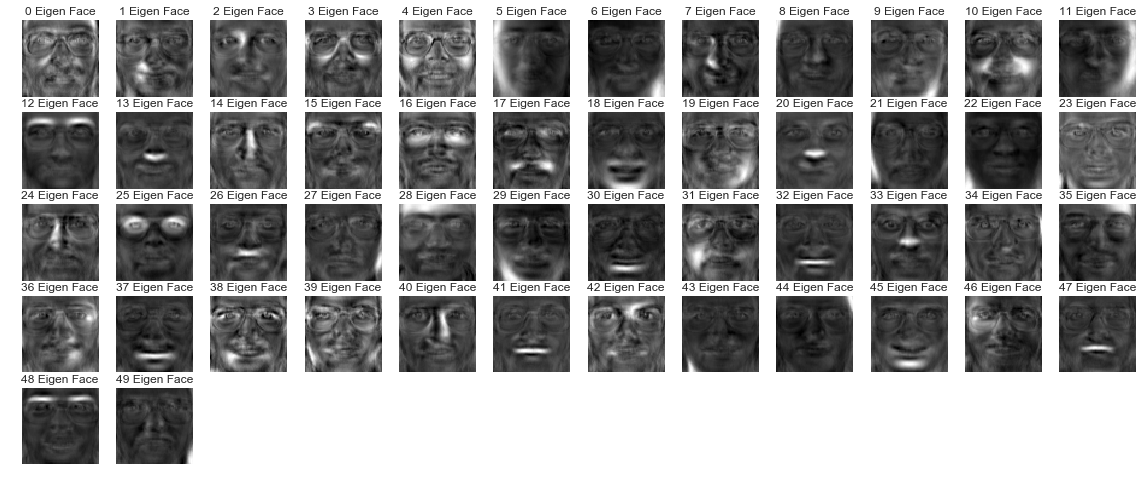

In [19]:
# view the indepedent images
resulted_images = sess.run(fica,feed_dict={x:sub_centered})
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    try: 
        sub_centered[i-1].all()
        fig.add_subplot(rows, columns, i)
        plt.imshow(resulted_images[i-1].reshape(64,64),cmap='gray')
        plt.axis('off')
        plt.title(str(i-1) + ' Eigen Face')
    except:
        pass
plt.show()